In [1]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
import numpy as np

BATCH_SIZE = 30
EPOCHS = 1000
SEED = 2

In [4]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences

train_labels, train_data = read_data('rp_train_data.txt')
val_labels, val_data = read_data('rp_test_data.txt')


In [5]:
train_data[:5]

['organization that church establish .',
 'organization that team join .',
 'organization that company sell .',
 'organization that soldier serve .',
 'organization that sailor join .']

In [19]:
type(train_data[0])

str

In [6]:
train_labels[:5]

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]

In [22]:
type(train_labels[0][1])

int

In [7]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [8]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

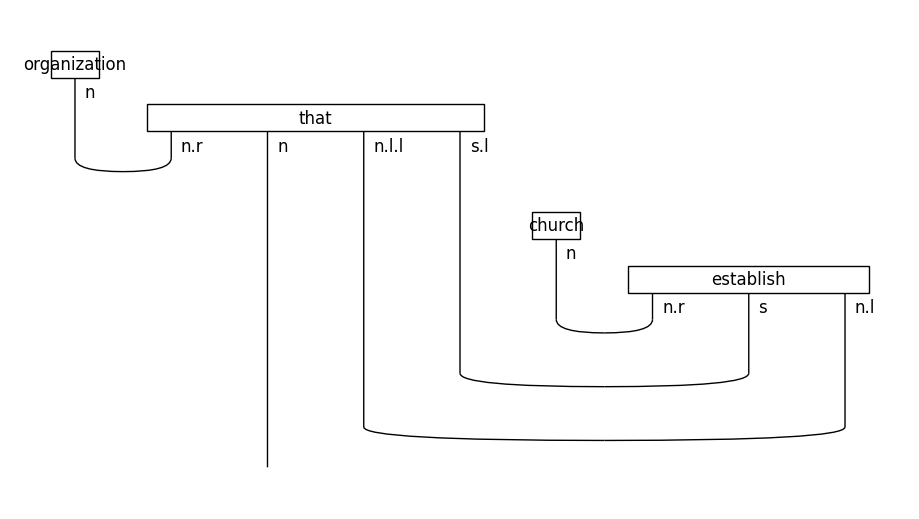

In [9]:
train_diagrams[0].draw(figsize=(9, 5), fontsize=12)

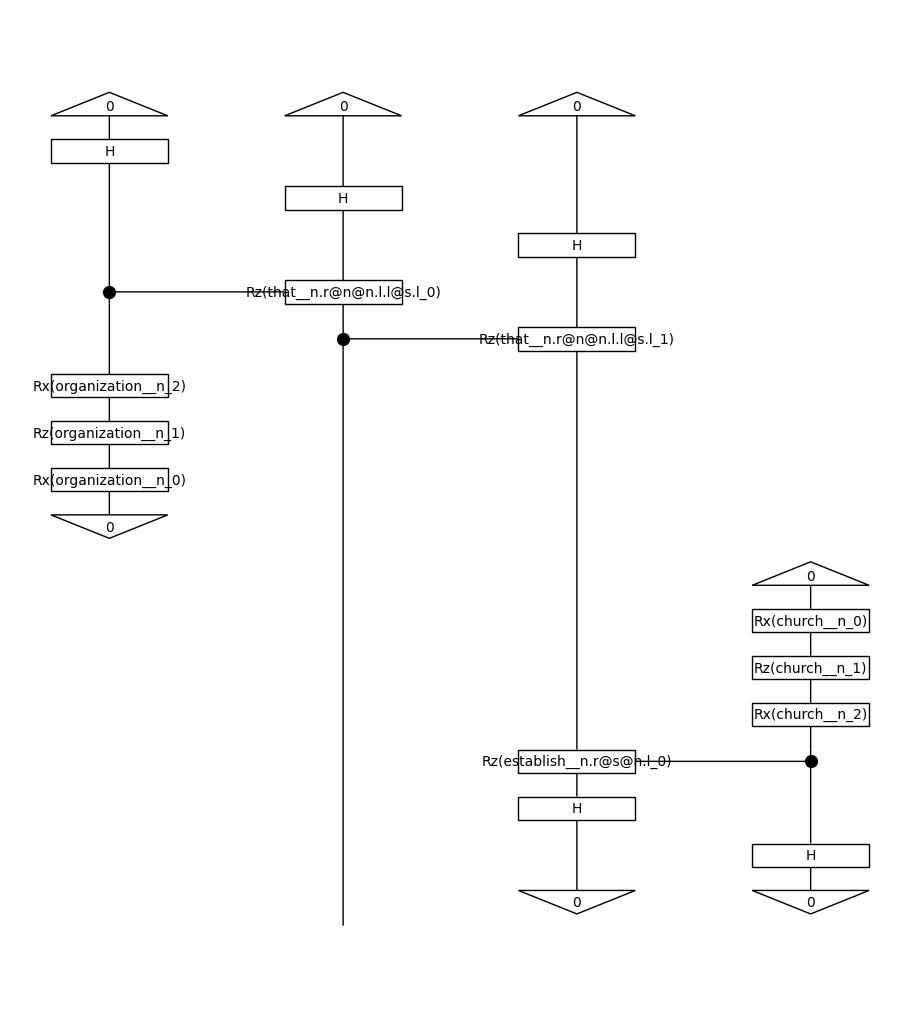

In [10]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

train_circuits[0].draw(figsize=(9, 10))

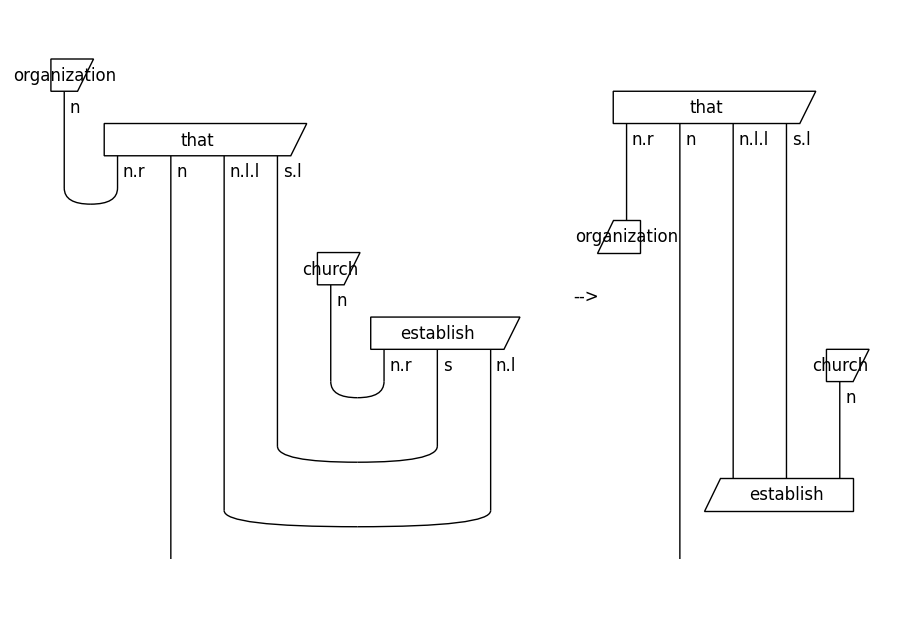

In [11]:
from discopy.drawing import equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(9, 6), asymmetry=0.3, fontsize=12)

In [12]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [13]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}


In [14]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [15]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [16]:
trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=100)

Epoch 1:     train/loss: 0.8875   valid/loss: 1.5880   train/acc: 0.6286   valid/acc: 0.5000
Epoch 100:   train/loss: 0.2760   valid/loss: 1.1021   train/acc: 0.8929   valid/acc: 0.7258
Epoch 200:   train/loss: 0.1741   valid/loss: 0.4057   train/acc: 0.9500   valid/acc: 0.7419


KeyboardInterrupt: 

Validation accuracy: 0.7580645161290323


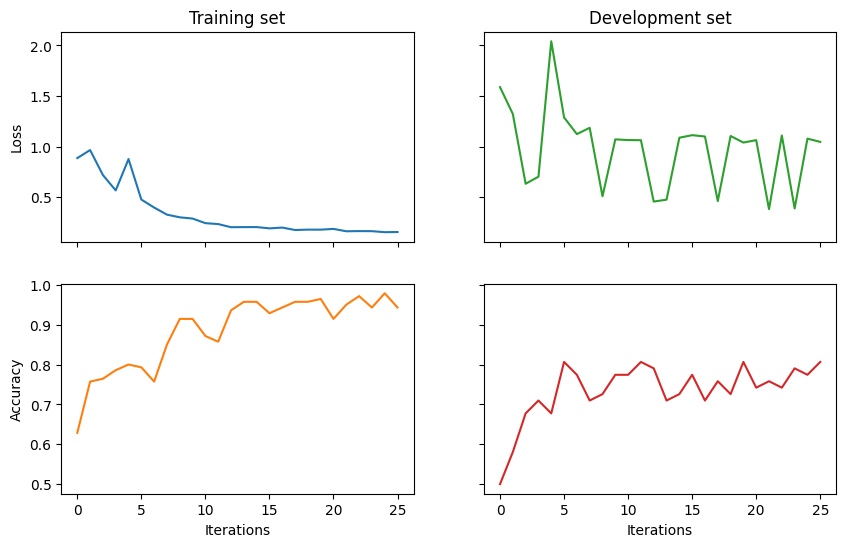

In [17]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

# print test accuracy
test_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())